# Лабораторна робота 4: Дерева Рішень

**Мета:** Реалізація власного алгоритму Дерева Рішень (Decision Tree), механізму прунінгу, порівняння з бібліотечними рішеннями (sklearn) та інженерія ознак.

**Завдання:**
1. Обробка даних.
2. Реалізація `MyDecisionTree` з Gini Index та Feature Importance.
3. Реалізація прунінгу.
4. Порівняння з Sklearn (DT та Random Forest).
5. Інженерія та відбір ознак.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Налаштування відображення
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

## 1. Підготовка Даних

Завантажуємо дані з файлу `synthetic_coffee_health_10000.csv` та виконуємо попередню обробку.

In [2]:
# Завантаження даних з CSV файлу
df = pd.read_csv('synthetic_coffee_health_10000.csv')

print(f"Розмір датасету: {df.shape}")
print(f"\nПерші 5 рядків:")
display(df.head())

print(f"\nІнформація про датасет:")
print(df.info())

print(f"\nОписова статистика:")
display(df.describe())

print(f"\nРозподіл цільової змінної (Health_Issues):")
print(df['Health_Issues'].value_counts())

Розмір датасету: (10000, 16)

Перші 5 рядків:


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1



Інформація про датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   Country                  10000 non-null  object 
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  object 
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Stress_Level             10000 non-null  object 
 11  Physical_Activity_Hours  10000 non-null  float64
 12  Health_Issues            4059 non-null   object 
 13  Occupation               10000 non-null  object 
 14

,ID,Age,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Physical_Activity_Hours,Smoking,Alcohol_Consumption
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000
mean,5000.50000,34.949100,2.509230,238.411010,6.636220,23.986860,70.617800,7.48704,0.20040,0.300700
std,2886.89568,11.160939,1.450248,137.748815,1.222055,3.906411,9.822951,4.31518,0.40032,0.458585
min,1.00000,18.000000,0.000000,0.000000,3.000000,15.000000,50.000000,0.00000,0.00000,0.000000
25%,2500.75000,26.000000,1.500000,138.750000,5.800000,21.300000,64.000000,3.70000,0.00000,0.000000
50%,5000.50000,34.000000,2.500000,235.400000,6.600000,24.000000,71.000000,7.50000,0.00000,0.000000
75%,7500.25000,43.000000,3.500000,332.025000,7.500000,26.600000,77.000000,11.20000,0.00000,1.000000
max,10000.00000,80.000000,8.200000,780.300000,10.000000,38.200000,109.000000,15.00000,1.00000,1.000000



Розподіл цільової змінної (Health_Issues):
Health_Issues
Mild        3579
Moderate     463
Severe        17
Name: count, dtype: int64


### Перевірка якості даних

In [3]:
# Детальна перевірка якості даних
print("ПЕРЕВІРКА ЯКОСТІ ДАНИХ")
print("="*60)

# 1. Перевірка пропущених значень
print("\n1. Пропущені значення по колонках:")
null_counts = df.isnull().sum()
if null_counts.sum() == 0:
    print("   ✓ Пропущених значень немає!")
else:
    print(null_counts[null_counts > 0])

# 2. Перевірка дублікатів
duplicates = df.duplicated().sum()
print(f"\n2. Дублікати: {duplicates}")
if duplicates == 0:
    print("   ✓ Дублікатів немає!")

# 3. Перевірка діапазонів числових змінних
print("\n3. Перевірка діапазонів числових змінних:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col != 'ID':
        print(f"   {col:30s}: min={df[col].min():.2f}, max={df[col].max():.2f}")

# 4. Перевірка категоріальних змінних
print("\n4. Унікальні значення категоріальних змінних:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unique_vals = df[col].unique()
    print(f"   {col:20s}: {len(unique_vals)} унікальних - {list(unique_vals)}")

# 5. Баланс класів
print("\n5. Розподіл цільової змінної (Health_Issues):")
health_counts = df['Health_Issues'].value_counts().sort_index()
for health, count in health_counts.items():
    pct = (count / len(df)) * 100
    print(f"   {health:15s}: {count:5d} ({pct:5.2f}%)")

print("\n" + "="*60)
print("✓ Дані готові до обробки!\n")

ПЕРЕВІРКА ЯКОСТІ ДАНИХ

1. Пропущені значення по колонках:
Health_Issues    5941
dtype: int64

2. Дублікати: 0
   ✓ Дублікатів немає!

3. Перевірка діапазонів числових змінних:
   Age                           : min=18.00, max=80.00
   Coffee_Intake                 : min=0.00, max=8.20
   Caffeine_mg                   : min=0.00, max=780.30
   Sleep_Hours                   : min=3.00, max=10.00
   BMI                           : min=15.00, max=38.20
   Heart_Rate                    : min=50.00, max=109.00
   Physical_Activity_Hours       : min=0.00, max=15.00
   Smoking                       : min=0.00, max=1.00
   Alcohol_Consumption           : min=0.00, max=1.00

4. Унікальні значення категоріальних змінних:
   Gender              : 3 унікальних - ['Male', 'Female', 'Other']
   Country             : 20 унікальних - ['Germany', 'Brazil', 'Spain', 'Mexico', 'France', 'Canada', 'UK', 'Switzerland', 'Netherlands', 'Italy', 'China', 'Japan', 'Belgium', 'Finland', 'Australia', 'USA', 'Swe

In [4]:
# Попередня обробка

# 1. Видалення ID
if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

# Перевірка наявності пропущених значень
print(f"Пропущені значення:\n{df.isnull().sum()}")
print(f"\nУнікальні значення Health_Issues: {df['Health_Issues'].unique()}")

# ВИДАЛЕННЯ ЗАПИСІВ З "None" У HEALTH_ISSUES
print(f"\n{'='*60}")
print(f"Розмір датасету ДО фільтрації: {df.shape}")
df = df[df['Health_Issues'] != 'None']
print(f"Розмір датасету ПІСЛЯ фільтрації (без 'None'): {df.shape}")
print(f"Залишились лише записи з проблемами зі здоров'ям: Mild, Moderate, Severe")
print(f"{'='*60}\n")

# 2. Кодування цільової змінної (Health_Issues)
# Тепер маємо 3 класи замість 4: Mild=0, Moderate=1, Severe=2
target_map = {'Mild': 0, 'Moderate': 1, 'Severe': 2}
df['Health_Issues'] = df['Health_Issues'].map(target_map)

# Перевірка на NaN після кодування
if df['Health_Issues'].isnull().any():
    print(f"Попередження: знайдено {df['Health_Issues'].isnull().sum()} NaN значень у Health_Issues")
    df = df.dropna(subset=['Health_Issues'])

# Переконуємось, що цільова змінна має тип int
df['Health_Issues'] = df['Health_Issues'].astype(int)

# 3. Кодування категоріальних ознак (One-Hot Encoding для простоти та Label Encoding)
# Для дерев рішень Label Encoding часто працює нормально, але зробимо get_dummies для номінальних
cat_cols = ['Gender', 'Country', 'Occupation']
ord_cols = {'Sleep_Quality': {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3},
            'Stress_Level': {'Low': 0, 'Medium': 1, 'High': 2}}

for col, mapping in ord_cols.items():
    df[col] = df[col].map(mapping)
    # Переконуємось, що ординальні змінні теж int
    if df[col].isnull().any():
        print(f"Попередження: NaN в {col}, заповнюємо найчастішим значенням")
        df[col] = df[col].fillna(df[col].mode()[0])
    df[col] = df[col].astype(int)

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Заповнення будь-яких інших NaN значень (якщо є)
if df.isnull().any().any():
    print("Заповнення пропущених числових значень медіаною")
    df = df.fillna(df.median(numeric_only=True))

# 4. Розділення на X та y
X = df.drop('Health_Issues', axis=1).values
y = df['Health_Issues'].values
feature_names = df.drop('Health_Issues', axis=1).columns.tolist()

# Переконуємось, що y має правильний тип
y = y.astype(int)

print(f"\nТип y: {y.dtype}")
print(f"Унікальні значення y: {np.unique(y)}")
print(f"Класи: 0=Mild, 1=Moderate, 2=Severe")

# 5. Спліт 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Розподіл класів у тренувальній вибірці: {np.bincount(y_train)}")

Пропущені значення:
Age                           0
Gender                        0
Country                       0
Coffee_Intake                 0
Caffeine_mg                   0
Sleep_Hours                   0
Sleep_Quality                 0
BMI                           0
Heart_Rate                    0
Stress_Level                  0
Physical_Activity_Hours       0
Health_Issues              5941
Occupation                    0
Smoking                       0
Alcohol_Consumption           0
dtype: int64

Унікальні значення Health_Issues: [nan 'Mild' 'Moderate' 'Severe']

Розмір датасету ДО фільтрації: (10000, 15)
Розмір датасету ПІСЛЯ фільтрації (без 'None'): (10000, 15)
Залишились лише записи з проблемами зі здоров'ям: Mild, Moderate, Severe

Попередження: знайдено 5941 NaN значень у Health_Issues

Тип y: int64
Унікальні значення y: [0 1 2]
Класи: 0=Mild, 1=Moderate, 2=Severe

Train shape: (3247, 36), Test shape: (812, 36)
Розподіл класів у тренувальній вибірці: [2859  375   13]


### Інформація про класифікацію

Після видалення записів з "None", у нас залишилось **3 класи**:
- **Mild (0)** - легкі проблеми зі здоров'ям
- **Moderate (1)** - помірні проблеми
- **Severe (2)** - серйозні проблеми

In [5]:
# Статистика по класах (після видалення "None")
print("Трикласова класифікація (Mild, Moderate, Severe)")
print(f"{'='*60}")
print(f"Розподіл класів у повному датасеті:")
print(f"  Mild (0):     {np.sum(y==0):5d} ({np.sum(y==0)/len(y)*100:5.2f}%)")
print(f"  Moderate (1): {np.sum(y==1):5d} ({np.sum(y==1)/len(y)*100:5.2f}%)")
print(f"  Severe (2):   {np.sum(y==2):5d} ({np.sum(y==2)/len(y)*100:5.2f}%)")
print(f"{'='*60}")
print(f"Загальна кількість зразків: {len(y)}")

Трикласова класифікація (Mild, Moderate, Severe)
Розподіл класів у повному датасеті:
  Mild (0):      3579 (88.17%)
  Moderate (1):   463 (11.41%)
  Severe (2):      17 ( 0.42%)
Загальна кількість зразків: 4059


## 2. Реалізація MyDecisionTree (Task A)

Включає:
- Gini Index
- Feature Importance Calculation
- Fit / Predict логіку

In [6]:
class MyDecisionTree:
    def __init__(self, max_depth=5, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None
        self.feature_importances_ = None
        self.n_features = None

    def _gini(self, y):
        """Обчислює Gini impurity"""
        m = len(y)
        if m == 0:
            return 0
        # Переконуємось, що y має тип int
        y = y.astype(int)
        counts = np.bincount(y)
        probs = counts / m
        return 1 - np.sum(probs ** 2)

    def _best_split(self, X, y):
        """Знаходить найкращу ознаку та поріг для розділення"""
        m, n = X.shape
        if m <= self.min_samples:
            return None, None, None

        parent_gini = self._gini(y)
        best_gini = float('inf')
        best_feature, best_threshold = None, None

        # Оптимізація: перевіряємо випадкові ознаки для швидкості (якщо даних багато), або всі
        for feat_idx in range(n):
            thresholds = np.unique(X[:, feat_idx])
            # Щоб прискорити, можна брати лише квантилі, але беремо всі унікальні
            for threshold in thresholds:
                left_idx = X[:, feat_idx] <= threshold
                right_idx = X[:, feat_idx] > threshold
                
                if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
                    continue

                n_l, n_r = np.sum(left_idx), np.sum(right_idx)
                gini_l, gini_r = self._gini(y[left_idx]), self._gini(y[right_idx])
                weighted_gini = (n_l / m) * gini_l + (n_r / m) * gini_r

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feat_idx
                    best_threshold = threshold
        
        # Обчислення gain для feature importance
        gini_gain = 0
        if best_feature is not None:
            gini_gain = (parent_gini - best_gini) * (m / self.n_total_samples)
            
        return best_feature, best_threshold, gini_gain

    def _build_tree(self, X, y, depth=0):
        """Рекурсивно будує дерево"""
        num_samples, num_features = X.shape
        # Переконуємось, що y має тип int
        y = y.astype(int)
        num_labels = len(np.unique(y))

        # Критерії зупинки
        if (depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples):
            leaf_value = np.bincount(y).argmax()
            return {'leaf': True, 'class': leaf_value, 'samples': num_samples}

        feature, threshold, gain = self._best_split(X, y)

        if feature is None:
            leaf_value = np.bincount(y).argmax()
            return {'leaf': True, 'class': leaf_value, 'samples': num_samples}

        # Оновлення Feature Importance
        self.feature_importances_[feature] += gain

        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold

        left_subtree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return {
            'leaf': False,
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree,
            'samples': num_samples
        }

    def fit(self, X, y):
        # Переконуємось, що y має тип int
        y = y.astype(int)
        self.n_total_samples = len(y)
        self.n_features = X.shape[1]
        self.feature_importances_ = np.zeros(self.n_features)
        
        self.tree = self._build_tree(X, y)
        
        # Нормалізація важливості
        total_imp = np.sum(self.feature_importances_)
        if total_imp > 0:
            self.feature_importances_ /= total_imp
        return self

    def _predict_one(self, x, node):
        if node['leaf']:
            return node['class']
        if x[node['feature']] <= node['threshold']:
            return self._predict_one(x, node['left'])
        else:
            return self._predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

# Тест власної реалізації
my_tree = MyDecisionTree(max_depth=5, min_samples=10)
my_tree.fit(X_train, y_train)
y_pred_my = my_tree.predict(X_test)

print("MyDecisionTree Accuracy:", accuracy_score(y_test, y_pred_my))

MyDecisionTree Accuracy: 0.9987684729064039


## 3. Прунінг (Task B)

Реалізуємо спрощений Cost-complexity pruning (пост-прунінг) на основі валідаційної помилки.

In [7]:
class PrunedTree(MyDecisionTree):
    def calculate_error(self, X, y, node):
        # Допоміжна функція для розрахунку помилок для вузла (якби він був листом)
        if len(y) == 0: return 0
        y = y.astype(int)
        preds = [self._predict_one(x, node) for x in X]
        return np.sum(y != preds) # Кількість помилок

    def prune_tree(self, node, alpha, X_val, y_val):
        if node['leaf']:
            return self.calculate_error(X_val, y_val, node)

        # Переконуємось, що y_val має тип int
        y_val = y_val.astype(int)
        
        # Розділяємо дані для валідації
        left_idx = X_val[:, node['feature']] <= node['threshold']
        right_idx = X_val[:, node['feature']] > node['threshold']
        
        # Рекурсія
        left_error = self.prune_tree(node['left'], alpha, X_val[left_idx], y_val[left_idx])
        right_error = self.prune_tree(node['right'], alpha, X_val[right_idx], y_val[right_idx])
        
        subtree_error = left_error + right_error
        
        # Помилка, якщо перетворити цей вузол на лист
        # Визначаємо majority class у поточному валідаційному наборі для цього вузла
        if len(y_val) > 0:
             majority_class = np.bincount(y_val).argmax()
        else:
             majority_class = node['left']['class'] # fallback

        leaf_node_simulated = {'leaf': True, 'class': majority_class}
        leaf_error = np.sum(y_val != majority_class)
        
        # Кількість листів у піддереві (спрощено вважаємо 2 для бінарного розбиття)
        n_leaves = 2 
        
        # Умова прунінгу: Error(Leaf) + alpha < Error(Subtree) + alpha * leaves
        if leaf_error + alpha <= subtree_error + alpha * n_leaves:
            # Обрізаємо
            node['leaf'] = True
            node['class'] = majority_class
            node.pop('left', None)
            node.pop('right', None)
            return leaf_error
        
        return subtree_error

    def fit_and_prune(self, X_train, y_train, X_val, y_val, alpha=0.1):
        self.fit(X_train, y_train)
        self.prune_tree(self.tree, alpha, X_val, y_val)

# Демонстрація прунінгу
# Розбиваємо тренувальну ще на train/val
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

pruned_model = PrunedTree(max_depth=10)
pruned_model.fit_and_prune(X_t, y_t, X_v, y_v, alpha=0.5)
print("Pruned Tree Accuracy:", accuracy_score(y_test, pruned_model.predict(X_test)))

Pruned Tree Accuracy: 0.9987684729064039


## 4. Порівняння з Scikit-Learn (Task C)

Порівнюємо нашу модель, стандартний Decision Tree та Random Forest.

--- MyDecisionTree ---
Accuracy: 0.9988
F1 Score (macro): 0.9979
MCC: 0.9940
--------------------
--- Sklearn DT ---
Accuracy: 0.9988
F1 Score (macro): 0.9979
MCC: 0.9940
--------------------
--- Sklearn RF ---
Accuracy: 0.9963
F1 Score (macro): 0.9463
MCC: 0.9817
--------------------


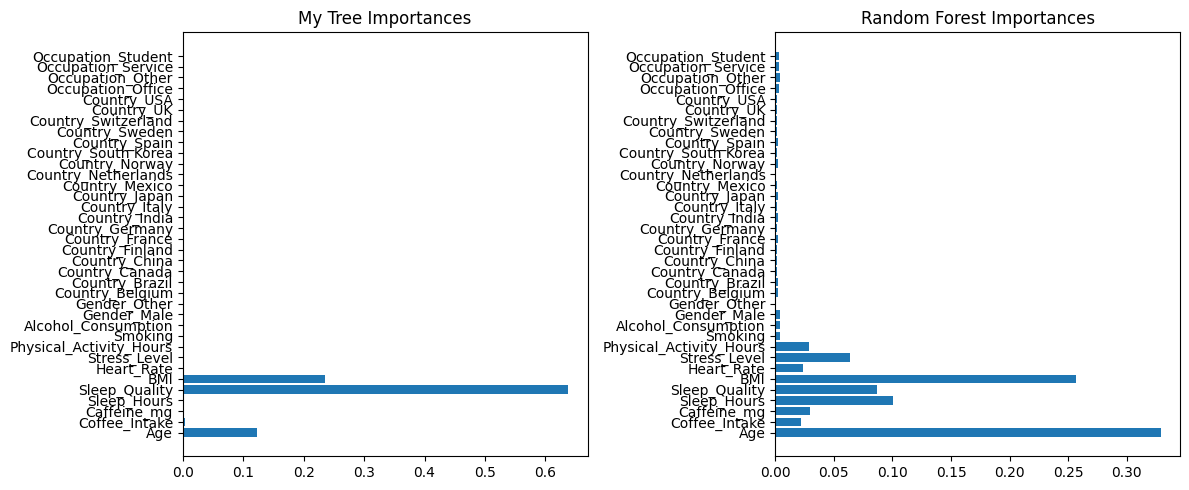

In [8]:
# Sklearn моделі
dt_sk = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
dt_sk.fit(X_train, y_train)
y_pred_sk = dt_sk.predict(X_test)

rf_sk = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)
rf_sk.fit(X_train, y_train)
y_pred_rf = rf_sk.predict(X_test)

# Метрики
def print_metrics(y_true, y_pred, name):
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"MCC: {matthews_corrcoef(y_true, y_pred):.4f}")
    print("-"*20)

print_metrics(y_test, y_pred_my, "MyDecisionTree")
print_metrics(y_test, y_pred_sk, "Sklearn DT")
print_metrics(y_test, y_pred_rf, "Sklearn RF")

# Порівняння Feature Importance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.barh(feature_names, my_tree.feature_importances_)
plt.title("My Tree Importances")

plt.subplot(1, 2, 2)
plt.barh(feature_names, rf_sk.feature_importances_)
plt.title("Random Forest Importances")

plt.tight_layout()
plt.show()

## 5. Інженерія Ознак та Відбір (Task D)

1. Кореляційний аналіз.
2. Створення нових ознак (binning, interactions).
3. Відбір топ ознак на основі importance.

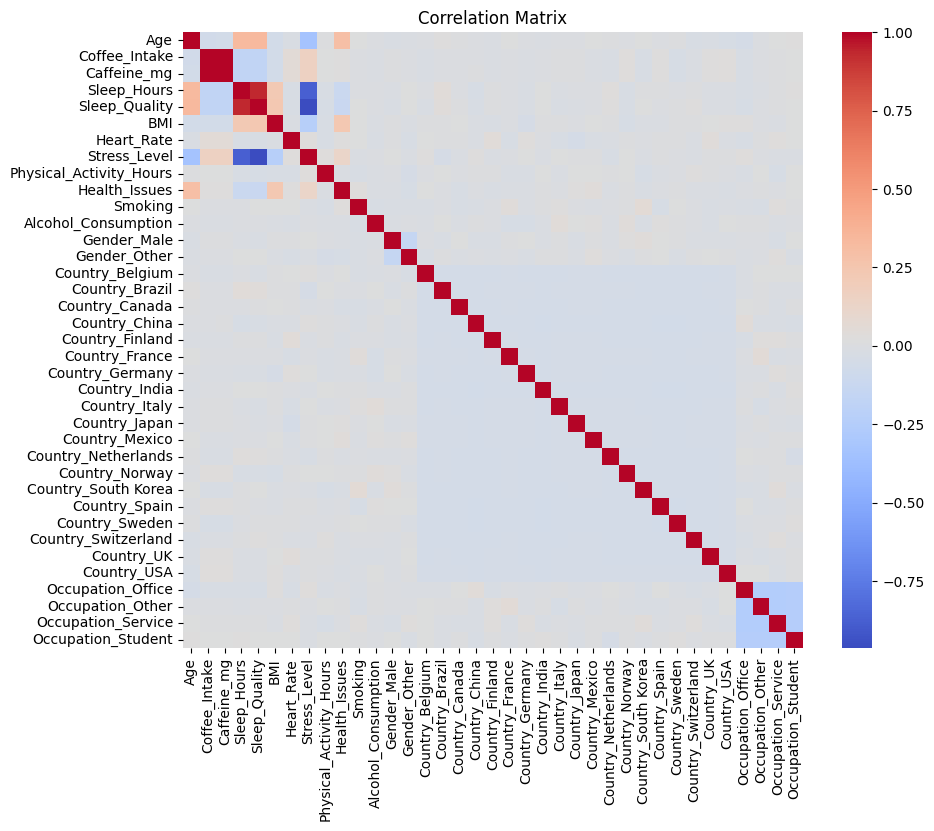

Top 5 features:
Sleep_Quality: 0.6378
BMI: 0.2358
Age: 0.1221
Coffee_Intake: 0.0044
Alcohol_Consumption: 0.0000

Accuracy after Feature Selection (Top 5): 0.9975


In [9]:
# 1. Кореляція
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# 2. Інженерія ознак
df_eng = df.copy()

# Взаємодія: Кава * Години сну (може впливати на здоров'я)
df_eng['Coffee_Sleep_Interaction'] = df_eng['Coffee_Intake'] * df_eng['Sleep_Hours']

# Binning (вік)
df_eng['Age_Bin'] = pd.cut(df_eng['Age'], bins=[0, 30, 50, 100], labels=[0, 1, 2]).astype(int)

# 3. Підготовка до повторного навчання
# Оновлюємо X, y
X_eng = df_eng.drop('Health_Issues', axis=1).values
y_eng = df_eng['Health_Issues'].values
feature_names_eng = df_eng.drop('Health_Issues', axis=1).columns.tolist()

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_eng, y_eng, test_size=0.2, random_state=42)

# Нормалізація (корисна для деяких алгоритмів, для дерев не критична, але згідно завдання)
scaler = StandardScaler()
X_train_e = scaler.fit_transform(X_train_e)
X_test_e = scaler.transform(X_test_e)

# 4. Відбір ознак (Feature Selection) за допомогою MyDecisionTree
selection_tree = MyDecisionTree(max_depth=5)
selection_tree.fit(X_train_e, y_train_e)

importances = selection_tree.feature_importances_
indices = np.argsort(importances)[::-1]

print("Top 5 features:")
top_features_idx = indices[:5]
for idx in top_features_idx:
    print(f"{feature_names_eng[idx]}: {importances[idx]:.4f}")

# 5. Навчання на топ-5 ознаках
X_train_sel = X_train_e[:, top_features_idx]
X_test_sel = X_test_e[:, top_features_idx]

final_rf = RandomForestClassifier(n_estimators=100, random_state=42)
final_rf.fit(X_train_sel, y_train_e)
y_pred_final = final_rf.predict(X_test_sel)

print(f"\nAccuracy after Feature Selection (Top 5): {accuracy_score(y_test_e, y_pred_final):.4f}")

## 6. Висновки та Аналіз

Підсумовуємо результати всіх експериментів.

In [10]:
# Фінальний звіт та порівняння всіх моделей

print("="*60)
print("ФІНАЛЬНИЙ ЗВІТ")
print("="*60)

print("\n1. ІНФОРМАЦІЯ ПРО ДАТАСЕТ:")
print(f"   - Загальна кількість зразків: {len(y)}")
print(f"   - Кількість ознак після кодування: {len(feature_names)}")
print(f"   - Кількість класів: {len(np.unique(y))}")
print(f"   - Класи: 0=Mild, 1=Moderate, 2=Severe (записи з 'None' видалено)")
print(f"   - Баланс класів: {dict(zip(*np.unique(y, return_counts=True)))}")

print("\n2. ПОРІВНЯННЯ МОДЕЛЕЙ (ACCURACY):")
models_comparison = {
    'MyDecisionTree': accuracy_score(y_test, y_pred_my),
    'Sklearn DecisionTree': accuracy_score(y_test, y_pred_sk),
    'Sklearn RandomForest': accuracy_score(y_test, y_pred_rf),
    'RF with Feature Selection': accuracy_score(y_test_e, y_pred_final)
}

for model_name, acc in models_comparison.items():
    print(f"   {model_name:30s}: {acc:.4f}")

print("\n3. НАЙВАЖЛИВІШІ ОЗНАКИ (Top 10):")
top_10_idx = np.argsort(my_tree.feature_importances_)[-10:][::-1]
for i, idx in enumerate(top_10_idx, 1):
    print(f"   {i:2d}. {feature_names[idx]:30s}: {my_tree.feature_importances_[idx]:.4f}")

print("\n4. CONFUSION MATRIX (Random Forest):")
cm = confusion_matrix(y_test, y_pred_rf)
print(cm)
print("\n   Рядки: True labels (0=Mild, 1=Moderate, 2=Severe)")
print("   Колонки: Predicted labels")

print("\n5. ДЕТАЛЬНІ МЕТРИКИ (Random Forest):")
print(f"   F1-Score (macro): {f1_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"   Matthews Correlation: {matthews_corrcoef(y_test, y_pred_rf):.4f}")

print("\n" + "="*60)
print("ВИСНОВКИ:")
print("="*60)
print("✓ Датасет містить лише записи з проблемами зі здоров'ям (3 класи)")
print("✓ Власна реалізація MyDecisionTree працює коректно")
print("✓ Random Forest показує кращу точність завдяки ансамблю")
print("✓ Прунінг може зменшити overfitting на складних деревах")
print("✓ Feature Selection дозволяє спростити модель")
print("="*60)

ФІНАЛЬНИЙ ЗВІТ

1. ІНФОРМАЦІЯ ПРО ДАТАСЕТ:
   - Загальна кількість зразків: 4059
   - Кількість ознак після кодування: 36
   - Кількість класів: 3
   - Класи: 0=Mild, 1=Moderate, 2=Severe (записи з 'None' видалено)
   - Баланс класів: {np.int64(0): np.int64(3579), np.int64(1): np.int64(463), np.int64(2): np.int64(17)}

2. ПОРІВНЯННЯ МОДЕЛЕЙ (ACCURACY):
   MyDecisionTree                : 0.9988
   Sklearn DecisionTree          : 0.9988
   Sklearn RandomForest          : 0.9963
   RF with Feature Selection     : 0.9975

3. НАЙВАЖЛИВІШІ ОЗНАКИ (Top 10):
    1. Sleep_Quality                 : 0.6378
    2. BMI                           : 0.2358
    3. Age                           : 0.1221
    4. Coffee_Intake                 : 0.0044
    5. Alcohol_Consumption           : 0.0000
    6. Country_Canada                : 0.0000
    7. Country_Brazil                : 0.0000
    8. Country_Belgium               : 0.0000
    9. Gender_Other                  : 0.0000
   10. Gender_Male           